In [1]:
# import relevant packages

%matplotlib inline

import PIL
import numpy as np
import pandas as pd
import torch
from easyimages import EasyImageList
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from skorch import *
from skorch.callbacks import (
    Callback,
    CyclicLR,
    Freezer,
    LRScheduler,
    PrintLog,
    scoring,
)
from skorch.utils import *
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import SGD
import os
import pickle

In [2]:
DEVICE='cpu'

In [4]:
# change working directory if you need to 
#os.getcwd()

os.chdir('/Users/lundr/DSRCompTwo')

In [5]:

# # Dataframes
path_df = "4.Data/X_bow_train_v2.pkl"
with open(path_df, 'rb') as data:
    X_bow_train = pickle.load(data)

path_df = "4.Data/X_bow_val_v2.pkl"
with open(path_df, 'rb') as data:
    X_bow_val = pickle.load(data)

path_df = "4.Data/X_TFIDF_train_v2.pkl"
with open(path_df, 'rb') as data:
    X_TFIDF_train = pickle.load(data)
    
path_df = "4.Data/X_TFIDF_val_v1.pkl"
with open(path_df, 'rb') as data:
    X_TFIDF_val = pickle.load(data)

path_df = "4.Data/Y_train_v2.pkl"
with open(path_df, 'rb') as data:
    Y_train = pickle.load(data)
    
path_df = "4.Data/Y_val_v2.pkl"
with open(path_df, 'rb') as data:
    Y_val = pickle.load(data)
    



In [6]:
Y_train = pd.DataFrame(Y_train)
Y_train = Y_train.fillna(0)

Y_val = pd.DataFrame(Y_val)
Y_val = Y_val.fillna(0)

In [7]:
#cpnvert to tensors
X_bow_train = torch.tensor(X_bow_train.values)
X_bow_val = torch.tensor(X_bow_val.values)
X_TFIDF_train = torch.tensor(X_TFIDF_train.values)
X_TFIDF_val = torch.tensor(X_TFIDF_val.values)

Y_train = torch.tensor(Y_train.values)
Y_val = torch.tensor(Y_val.values)

Y_train = torch.reshape(Y_train,(len(Y_train),1))
Y_val = torch.reshape(Y_val,(len(Y_val),1))
#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
class BoWClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self,num_labels, vocab_size):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(BoWClassifier, self).__init__()
        
        self.layer1=nn.Sequential(
            nn.Linear(10225,100),
            nn.ReLU() 
        )
        
        self.layer2=nn.Sequential(
            nn.Linear(100,100),
            nn.ReLU() 
        )
        self.layer3=nn.Sequential(
            nn.Linear(100,64),
            nn.ReLU() 
        )
               
        self.layer4=nn.Sequential(
            nn.Linear(64,1),
            nn.Sigmoid() 
        )
#
    def forward(self, x):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        
        return out




In [9]:
NUM_LABELS=1
VOCAB_SIZE=10225
model = BoWClassifier(1,10225)
model

# one of ['ASGD','Adadelta', 'Adagrad','Adam', 'Adamax','LBFGS', 'RMSprop','Rprop','SGD',SparseAdam']
parameters = model.parameters()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

model.to(DEVICE)

BoWClassifier(
  (layer1): Sequential(
    (0): Linear(in_features=10225, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [10]:
X=X_TFIDF_train.float()
Y=Y_train.float()
N_EPOCHS = 2
loss_history = []
BATCH_SIZE = 100

#model =BoWClassifier(1,10225)
#model = model

for epoch in range(N_EPOCHS):
    print("training epoch {}".format(epoch))
    for xsample,ysample in zip(X, Y):
         
        # zero the gradients
        # batch preparation
        
        x = xsample
        y = ysample.squeeze()

        #x = torch.Tensor(xsample).unsqueeze(0) # tensor([[0.8745, 0.5205]]) torch.Size([1, 2])
        #y = torch.Tensor([ysample]).unsqueeze(0) # tensor([[1.]]) torch.Size([1, 1])
        x = x.to(DEVICE)
        y = y.to(DEVICE)

#         What will this do once uncommented?
#         if True:
#             ix = np.random.randint(0, size=(16,), high=len(X))
#             x = torch.tensor((X[ix, :])).float()
#             y = torch.tensor(torch.Tensor(Y[ix]).reshape(-1,1)).float()
#             x = x.to(DEVICE)
#             y = y.to(DEVICE)


        # forward pass
        out =   model(x) # prediction, y_hat, 

        # loss calculation
        loss = criterion(out, y)
        # calculating gradients
        optimizer.zero_grad()
        loss.backward()
        
        # changing the weights by specified(in the optimizer init) learning rate
        optimizer.step()

        #append calculated loss to the history
        loss  = loss.detach().cpu().numpy()
        loss_history.append(loss)   
        

training epoch 0


C:\Users\lundr\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


training epoch 1


In [11]:
#net.layer1[0].weight

Parameter containing:
tensor([[ 0.0137, -0.0260, -0.0321,  ..., -0.0569,  0.0281,  0.0498],
        [ 0.0470, -0.0510,  0.0386,  ..., -0.0541, -0.0519, -0.0534],
        [-0.0530,  0.0414,  0.0127,  ...,  0.0510, -0.0351,  0.0532],
        ...,
        [-0.0277,  0.0484,  0.0006,  ...,  0.0517,  0.0063, -0.0028],
        [-0.0257, -0.0129, -0.0302,  ...,  0.0157, -0.0352, -0.0552],
        [ 0.0499,  0.0126, -0.0209,  ..., -0.0072,  0.0262,  0.0327]],
       dtype=torch.float64, requires_grad=True)

In [12]:
X_TFIDF_val=X_TFIDF_val.float()
Y_val=Y_val.float()

preds=[]
actual=[]
logprob = []
for instance, label in zip(X_TFIDF_val, Y_val):
    bow_vec = torch.tensor(instance)
    logprobs = model(bow_vec)
    #print(logprobs)
    pred=1 if logprobs>0.5 else 0
    #print('prediction: {}'.format([pred]))
    #print('actual: {}'.format(label))
    preds.append(pred)
    actual.append(label)
    logprob.append(logprobs)


C:\Users\lundr\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [109]:
Y_val=Y_val.double()

preds=torch.tensor(preds, dtype=torch.float64)
actual=torch.tensor(actual,dtype=torch.float64)
#Accuracy    
#value_when_true if condition else value_when_false
correct=[]
for i in range(len(preds)):
    if preds[i] == Y_val[i]:
        correct.append(1)
    else:
        correct.append(0)
correct =sum(correct)
print("Accuracy: {:.3f}".format(correct/len(Y_val)))


Accuracy: 0.536


In [110]:
from sklearn.metrics import roc_auc_score

metric = roc_auc_score(Y_val, preds)
print(metric)

0.5138733407964177


Text(0, 0.5, 'loss (CE)')

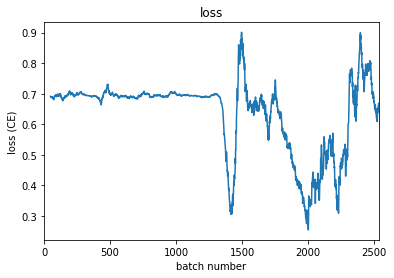

In [105]:
history = pd.DataFrame(loss_history, columns=['loss'])
history.loss[:10000].rolling(50).mean().plot()
plt.title("loss")
plt.xlabel("batch number")
plt.ylabel("loss (CE)")

